# 自订的输入层及辨识层(Dense)

## 载入套件

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

## 步骤1：载入 Flower 资料

In [2]:
# 资料集来源：https://www.tensorflow.org/tutorials/load_data/images

# 参数设定
batch_size = 64
img_height = 224
img_width = 224
data_dir = './flower_photos/'

# 载入 Flower 训练资料
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# 载入 Flower 验证资料
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## 步骤2：进行特征工程，将特征缩放成(0, 1)之间

In [3]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## 显示 ResNet152V2 完整的模型结构

In [4]:
base_model = ResNet152V2(weights='imagenet')
print(base_model.summary())

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [5]:
len(base_model.layers)

566

## 步骤3：建立模型结构

In [6]:
# 预先训练好的模型 -- ResNet152V2
base_model = ResNet152V2(weights='imagenet', include_top=False)
print(base_model.summary())

# 加上自订的辨识层(Dense)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)

# 指定自订的输入层及辨识层(Dense)
model = Model(inputs=base_model.input, outputs=predictions)

# 模型前段不需训练了
for layer in base_model.layers:
    layer.trainable = False

# 设定优化器(optimizer)、损失函数(loss)、效能衡量指标(metrics)的类别
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

## 步骤5：模型训练

In [8]:
# 设定快取(cache)、prefetch，以增进训练效率
AUTOTUNE = tf.data.AUTOTUNE
normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 模型训练
history = model.fit(normalized_ds, validation_data = normalized_val_ds, epochs=5)

Epoch 1/5
46/46 [==============================] - 594s 12s/step - loss: 1.1207 - accuracy: 0.5916 - val_loss: 0.5183 - val_accuracy: 0.8311
Epoch 2/5
46/46 [==============================] - 564s 12s/step - loss: 0.4140 - accuracy: 0.8512 - val_loss: 0.4265 - val_accuracy: 0.8597
Epoch 3/5
46/46 [==============================] - 565s 12s/step - loss: 0.3042 - accuracy: 0.9000 - val_loss: 0.3945 - val_accuracy: 0.8733
Epoch 4/5
46/46 [==============================] - 579s 13s/step - loss: 0.2455 - accuracy: 0.9218 - val_loss: 0.3813 - val_accuracy: 0.8747
Epoch 5/5
46/46 [==============================] - 540s 12s/step - loss: 0.2063 - accuracy: 0.9392 - val_loss: 0.3768 - val_accuracy: 0.8774


## 步骤6：绘制训练时准确率/损失函数的变化

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

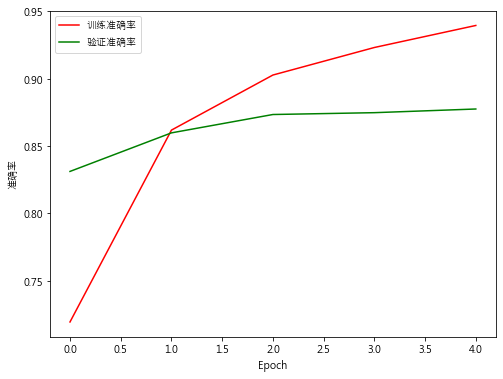

In [16]:
# 对训练过程的准确率绘图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='训练准确率')
plt.plot(history.history['val_accuracy'], 'g', label='验证准确率')
plt.xlabel('Epoch')
plt.ylabel('准确率')
plt.legend()

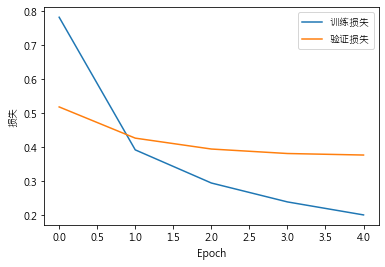

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label = '验证损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()

## 步骤7：预测

In [18]:
# 显示辨识的类别
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [19]:
# 任选一张图片，例如玫瑰
img_path = './images_test/rose.png'
# 载入图档，并缩放宽高为 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))

# 加一维，变成 (1, 224, 224, 3)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 预测
preds = model.predict(x)

# 显示预测结果
y_pred = [round(i * 100, 2) for i in preds[0]]
print(f'预测机率(%)：{y_pred}')
print(f'预测类别：{class_names[np.argmax(preds)]}')

预测机率(%)：[0.01, 0.0, 99.26, 0.22, 0.51, 0.0, 0.0, 0.0, 0.0, 0.0]
预测类别：roses


In [20]:
# 任选一张图片，例如雏菊
img_path = './images_test/daisy2.jpg'
# 载入图档，并缩放宽高为 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))

# 加一维，变成 (1, 224, 224, 3)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 预测
preds = model.predict(x)

# 显示预测结果
y_pred = [round(i * 100, 2) for i in preds[0]]
print(f'预测机率(%)：{y_pred}')
print(f'预测类别：{class_names[np.argmax(preds)]}')

预测机率(%)：[30.68, 47.97, 2.33, 15.82, 3.2, 0.0, 0.0, 0.0, 0.0, 0.0]
预测类别：dandelion
